## Overview

This is a demo. 

Process:


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys
import datetime as dt
import seaborn as sns

# Import the QPPQ model
from QPPQModel import StreamflowGenerator


In [4]:
# Model generation specifications
full_date_range = ('1955-01-01', '2022-12-31')
N_ENSEMBLE = 50
K = 5
donor_fdc = 'nhmv10'
hru_scaled = False

# Constants
cms_to_mgd = 22.82
fdc_quantiles = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]

# Directory to pywrdrb input data folder
pywrdrb_directory = '../Pywr-DRB'

obs_pub_site_matches = {'cannonsville': ['01423000', '0142400103'], # 0142400103 doesnt start until '96 ##TODO: PUB until 96
                    'pepacton': ['01415000', '01414500', '01414000', '01413500'], # '01414000' doesnt start until 1996; likely underestimate before
                    'neversink': ['01435000'],
                    'wallenpaupack': None, 
                    'prompton': ['01428750'],       ## PUB #TODO: PUB till 1986-09-30 then '01428750' observation start
                    'shoholaMarsh': None, 
                    'mongaupeCombined': None, 
                    'beltzvilleCombined': ['01449360'],  ## Not complete inflow                              
                    'fewalter': ['01447720', '01447500'],
                    'merrillCreek': None, 
                    'hopatcong': None,   
                    'nockamixon': None, 
                    'assunpink': None,  
                    'ontelaunee': None, 
                    'stillCreek': None, 
                    'blueMarsh': None,  
                    'greenLane': ['01472199', '01472198'],   # PUB until 1981
                    'marshCreek': None,  
                    '01425000': None,
                    '01417000': None,
                    'delLordville': ['01427207'], # PUB until 2006 then '01427207'
                    '01436000': None,
                    '01433500': None, 
                    'delMontague': ['01438500'],
                    '01449800': None,
                    '01447800': None,
                    'delDRCanal': ['01463500'], ### note DRCanal and Trenton are treated as being coincident, with DRCanal having the physical catchment inflows and withdrawals. DRCanal is where NJ deliveries leave from, and delTrenton is where min flow is enforced, so that this is downstream of deliveries.
                    'delTrenton': ['01463500'],
                    '01463620': None, 
                    'outletAssunpink': ['01464000'],
                    '01470960': None, 
                    'outletSchuylkill': ['01474500'],
                    'outletChristina': ['01481500', '01478650'],
                    }

# Downstream of blue marsh that needs to be removed
managed_gauges= ['01471000']

pywrdrb_sites = []
pywrdrb_node_site_keys = []
for node, sites in obs_pub_site_matches.items():
    if sites is not None:
        for s in sites:
            pywrdrb_sites.append(f'USGS-{s}')
            pywrdrb_node_site_keys.append(node)


In [5]:

### Load data 
Q = pd.read_csv(f'./data/historic_unmanaged_streamflow_1900_2022_cms.csv', sep = ',', index_col = 0, parse_dates=True)*cms_to_mgd
nhm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nhmv10.csv', sep =',',  index_col = 0, parse_dates=True)
nwm_flow = pd.read_csv(f'{pywrdrb_directory}/input_data/gage_flow_nwmv21.csv', sep =',',  index_col = 0, parse_dates=True)

gauge_meta = pd.read_csv(f'./data/drb_usgs_metadata.csv', sep = ',', dtype = {'site_no':str})
gauge_meta.set_index('site_no', inplace=True)

# Some gauge data is faulty
gauge_meta.loc['01414000', 'begin_date'] = '1996-12-05'
gauge_meta.loc['0142400103', 'begin_date'] = '1996-12-05'

prediction_locations = pd.read_csv(f'./data/prediction_locations.csv', sep = ',', index_col=0)

node_fdcs = pd.DataFrame(index = prediction_locations.index, columns=fdc_quantiles)
if donor_fdc == 'nhmv10':
    fdc_donor_flow = nhm_flow
elif donor_fdc == 'nwmv21':
    fdc_donor_flow = nwm_flow
    
for i, node in enumerate(prediction_locations.index):
    node_fdcs.loc[node, :] = np.quantile(fdc_donor_flow.loc[:,node], fdc_quantiles)

In [7]:
"""
figsize= (3,3)
fig, ax = plt.subplots(figsize= figsize)

cmap = mpl.colors.ListedColormap(['cornflowerblue', 'linen'])
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
avail = Q.groupby(Q.index.year).mean().isna().astype(int)
sns.heatmap(avail.transpose(), ax = ax, cmap = cmap, cbar=False)

#ax.set_xticklabels(Q.groupby(Q.index.year).mean().index)
ax.set_yticklabels([])
plt.ylabel('Site', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.show()

# Re-make with focus on 1960 onward
fig, ax = plt.subplots(figsize= figsize)
avail = Q.loc['1960-01-01':,:].groupby(Q.loc['1960-01-01':,:].index.year).mean().isna().astype(int)
sns.heatmap(avail.transpose(), ax = ax, cmap = cmap, cbar=False)

#ax.set_xticklabels(Q.groupby(Q.index.year).mean().index)
ax.set_yticklabels([])
plt.ylabel('Site', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Re-make with focus on only Pywr-DRB nodes and 1960 onward
fig, ax = plt.subplots(figsize= (5,5))
avail = Q.loc['1960-01-01':,pywrdrb_sites].groupby(Q.loc['1960-01-01':,pywrdrb_sites].index.year).mean().isna().astype(int)
sns.heatmap(avail.transpose(), ax = ax, cmap = cmap, cbar=False)

#ax.set_xticklabels(Q.groupby(Q.index.year).mean().index)
ax.set_yticklabels(pywrdrb_node_site_keys)
plt.ylabel('Site', fontsize=14)
plt.xlabel('Year', fontsize=14)
"""

"\nfigsize= (3,3)\nfig, ax = plt.subplots(figsize= figsize)\n\ncmap = mpl.colors.ListedColormap(['cornflowerblue', 'linen'])\nbounds = [0., 0.5, 1.]\nnorm = mpl.colors.BoundaryNorm(bounds, cmap.N)\navail = Q.groupby(Q.index.year).mean().isna().astype(int)\nsns.heatmap(avail.transpose(), ax = ax, cmap = cmap, cbar=False)\n\n#ax.set_xticklabels(Q.groupby(Q.index.year).mean().index)\nax.set_yticklabels([])\nplt.ylabel('Site', fontsize=14)\nplt.xlabel('Year', fontsize=14)\nplt.show()\n\n# Re-make with focus on 1960 onward\nfig, ax = plt.subplots(figsize= figsize)\navail = Q.loc['1960-01-01':,:].groupby(Q.loc['1960-01-01':,:].index.year).mean().isna().astype(int)\nsns.heatmap(avail.transpose(), ax = ax, cmap = cmap, cbar=False)\n\n#ax.set_xticklabels(Q.groupby(Q.index.year).mean().index)\nax.set_yticklabels([])\nplt.ylabel('Site', fontsize=14)\nplt.xlabel('Year', fontsize=14)\n\n# Re-make with focus on only Pywr-DRB nodes and 1960 onward\nfig, ax = plt.subplots(figsize= (5,5))\navail = Q.lo

In [9]:
# Remove outflow gauges from flow data
for node, sites in obs_pub_site_matches.items():
    if f'USGS-{node}' in Q.columns:
        Q = Q.drop(f'USGS-{node}', axis=1)

for site in managed_gauges:
    if f'USGS-{site}' in Q.columns:
        Q = Q.drop(f'USGS-{site}', axis=1)
        
# Make sure other inflow gauges are in the dataset
missing = 0
for node, sites in obs_pub_site_matches.items():
    if sites is not None:
        for s in sites:
            if f'USGS-{s}' not in Q.columns:
                print(f'Site {s} is not available')
assert(missing == 0), 'Atleast one of the inflow gauge timeseries if not available in the data.'

In [10]:
# Set-up QPPQ
reconstructed_sites = []
for node, sites in obs_pub_site_matches.items():
    if node == 'delDRCanal':
        pass
    elif sites is None:
        reconstructed_sites.append(node)
    else:
        for s in sites:
            reconstructed_sites.append(s)

# Intialize storage
max_daterange = pd.date_range('1955-01-01', '2022-12-31')
max_annual_NA_fill = 20
Q_reconstructed = pd.DataFrame(index=max_daterange, columns = reconstructed_sites)

N_YEARS = int(np.floor(len(max_daterange)/365))

starts = [f'{1955+i}-01-01' for i in range(N_YEARS)]
ends = [f'{1955+i}-12-31' for i in range(N_YEARS)]
daterange_subsets = np.vstack([starts, ends]).transpose()
assert(pd.to_datetime(daterange_subsets[-1,-1]).date() <= Q.index.max().date()), 'The historic data must be more recent than QPPQ daterange.'

In [12]:
## QPPQ prediction
# Generate 1 year at a time, to maximize the amount of data available for each years QPPQ
for i, dates in enumerate(daterange_subsets):
    # Run predictions one location at a time
    for node, sites in obs_pub_site_matches.items():
        
        # Pull gauges that have flow during daterange
        Q_subset = Q.loc[dates[0]:dates[1], :].dropna(axis=1)
        subset_sites = [f'{i.split("-")[1]}' for i in Q_subset.columns]
        gauge_meta_subset = gauge_meta.loc[subset_sites, :]
        gauge_meta_subset.index = Q_subset.columns
        
        # Initialize the model
        model = StreamflowGenerator(K= K,
                                    observed_flow = Q_subset, 
                                    observation_locations=gauge_meta_subset,
                                    probabalistic_sample = False)

        # Handle sites with historic data
        if sites is not None:
            for s in sites:
                # First, use observation data if available
                number_of_nas = Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna().sum()
                if (number_of_nas == 0):
                    Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                elif (number_of_nas <= max_annual_NA_fill):
                    print(f'Filling {number_of_nas} NAs for site {s} using median.')
                    Q_reconstructed.loc[dates[0]:dates[1], s] = Q.loc[dates[0]:dates[1], f'USGS-{s}'].values
                    
                    # Fill NA using median                    
                    na_indices = Q.loc[dates[0]:dates[1],:].loc[Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), :].index
                    median_flow = np.median(Q.loc[dates[0]:dates[1], :].loc[~Q.loc[dates[0]:dates[1], f'USGS-{s}'].isna(), f'USGS-{s}'])
                    Q_reconstructed.loc[na_indices.date, s] = median_flow
                        
                # If flow data isn't available, use historic observation to generate FDC and make PUB predictions
                else:
                    location = gauge_meta.loc[s, ['long', 'lat']].values
                    incomplete_site_flows = Q.loc[:, f'USGS-{s}'].dropna(axis=0)
                    
                    # Only use site flows for FDC if longer than 10-year record
                    if len(incomplete_site_flows)/365 >= 10:
                        fdc = np.quantile(incomplete_site_flows.values, fdc_quantiles)
                    else:
                        fdc = node_fdcs.loc[node, :].astype('float').values            
        
                    Q_reconstructed.loc[dates[0]:dates[1], s] = model.predict_streamflow(location, fdc).values.flatten()
            
        else:
            location = prediction_locations.loc[node, ['long', 'lat']].values
            fdc = node_fdcs.loc[node, :].astype('float').values

            Q_reconstructed.loc[dates[0]:dates[1], node] = model.predict_streamflow(location, fdc).values.flatten()

assert(Q_reconstructed.isna().sum().sum() == 0), 'There are NA values in the reconstruction.'    

Filling 2 NAs for site 01478650 using median.
Filling 2 NAs for site 01427207 using median.
Filling 3 NAs for site 01474500 using median.
Filling 9 NAs for site 01474500 using median.
Filling 5 NAs for site 01481500 using median.
Filling 5 NAs for site 01478650 using median.


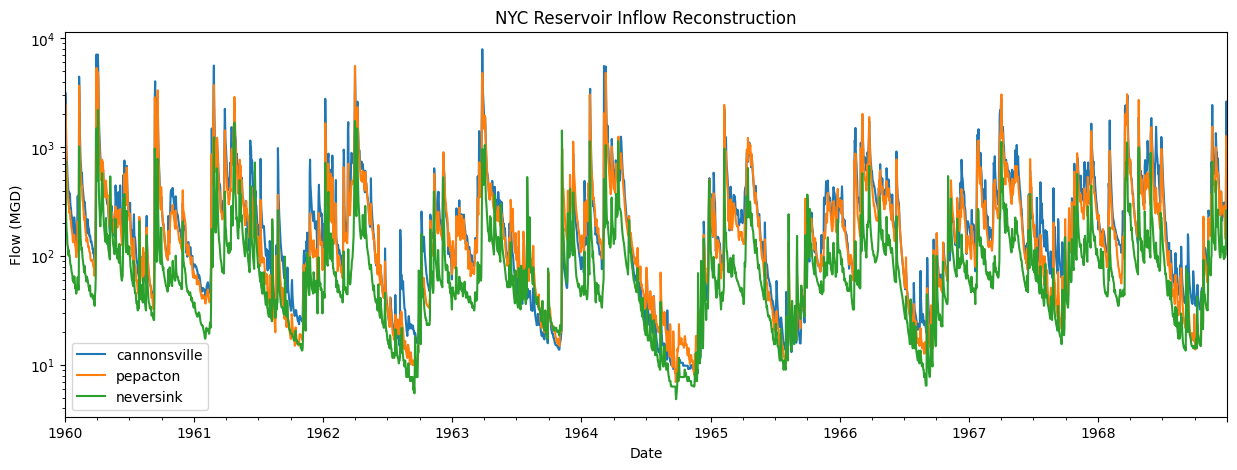

In [213]:
NYC_reservoirs = ['cannonsville', 'pepacton', 'neversink']

plot_start = '1960-01-01'
plot_end = '1968-12-31'
fig, ax = plt.subplots(figsize= (15,5))

for r in NYC_reservoirs:
    inflow_gauges = obs_pub_site_matches[r]
    Q_reconstructed.loc[plot_start:plot_end, inflow_gauges].sum(axis=1).plot(ax=ax, alpha = 1, figsize = (15,5), label = r)
plt.yscale('log')
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')
plt.title('NYC Reservoir Inflow Reconstruction')
plt.legend()


Text(0.5, 0, 'Date')

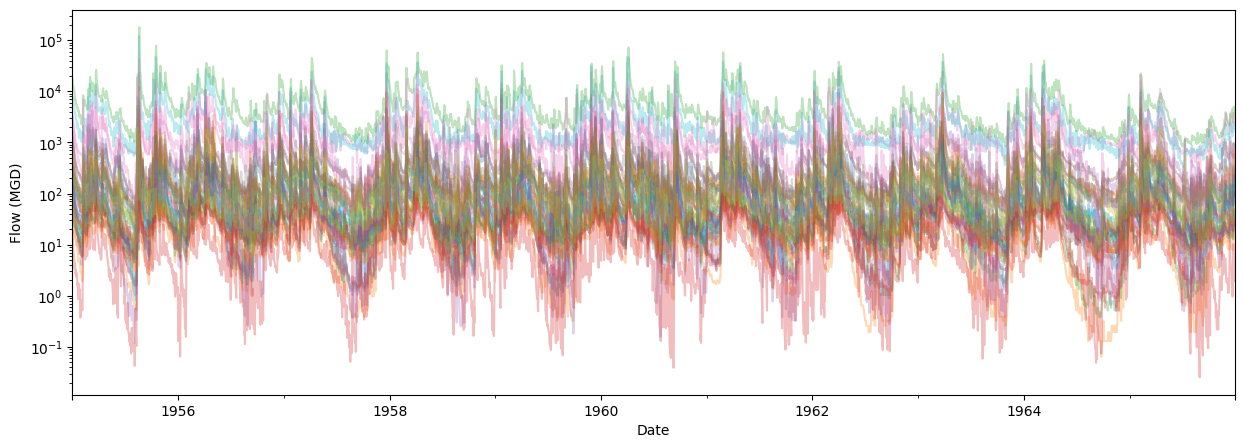

In [20]:

plot_start = '1955-01-01'
plot_end = '1965-12-31'
fig, ax = plt.subplots(figsize= (15,5))
Q_reconstructed.loc[plot_start:plot_end, :].plot(alpha = 0.3, figsize = (15,5), legend = False, ax=ax)
plt.yscale('log')
plt.ylabel('Flow (MGD)')
plt.xlabel('Date')
# plt.title('NYC Reservoir Inflow Reconstruction')
# plt.legend()

In [17]:
## Export
Q_reconstructed.to_csv(f'./outputs/historic_reconstruction_1960-2022_mgd.csv', sep = ',')
if hru_scaled:
    Q_reconstructed.to_csv(f'{pywrdrb_directory}/input_data/modeled_gages/historic_reconstruction_daily_1960_2022_{donor_fdc}_hru_scaled_mgd.csv', sep = ',')
else:
    Q_reconstructed.to_csv(f'{pywrdrb_directory}/modeled_gages/input_data/historic_reconstruction_daily_1960_2022_{donor_fdc}_mgd.csv', sep = ',')

***
### QPPQ Ensemble Generation

Here we consider an ensemble of generated the historic reconstruction timeseries using a probabalistic variation of the QPPQ method.  

In [96]:
## Run model predictions
model = StreamflowGenerator(K= K,
                            observed_flow = Q, 
                            observation_locations=gauge_meta,
                            probabalistic_sample = True)

In [101]:
node_ensembles = {}


In [102]:
# Specify prediction location data
node = 'delLordville'
location = prediction_locations.loc[node, ['long', 'lat']].values
fdc = nhm_fdc.loc[node, :].values
datetime = pd.date_range(start_date, end_date)

# Intialize storage
QPPQ_ensemble = np.zeros((14610, N_ENSEMBLE))

for i in range(N_ENSEMBLE):
    QPPQ_ensemble[:, i] = model.predict_streamflow(location, fdc).values.flatten()
node_ensembles[node] = QPPQ_ensemble

Text(0.5, 1.0, 'delLordville Inflow')

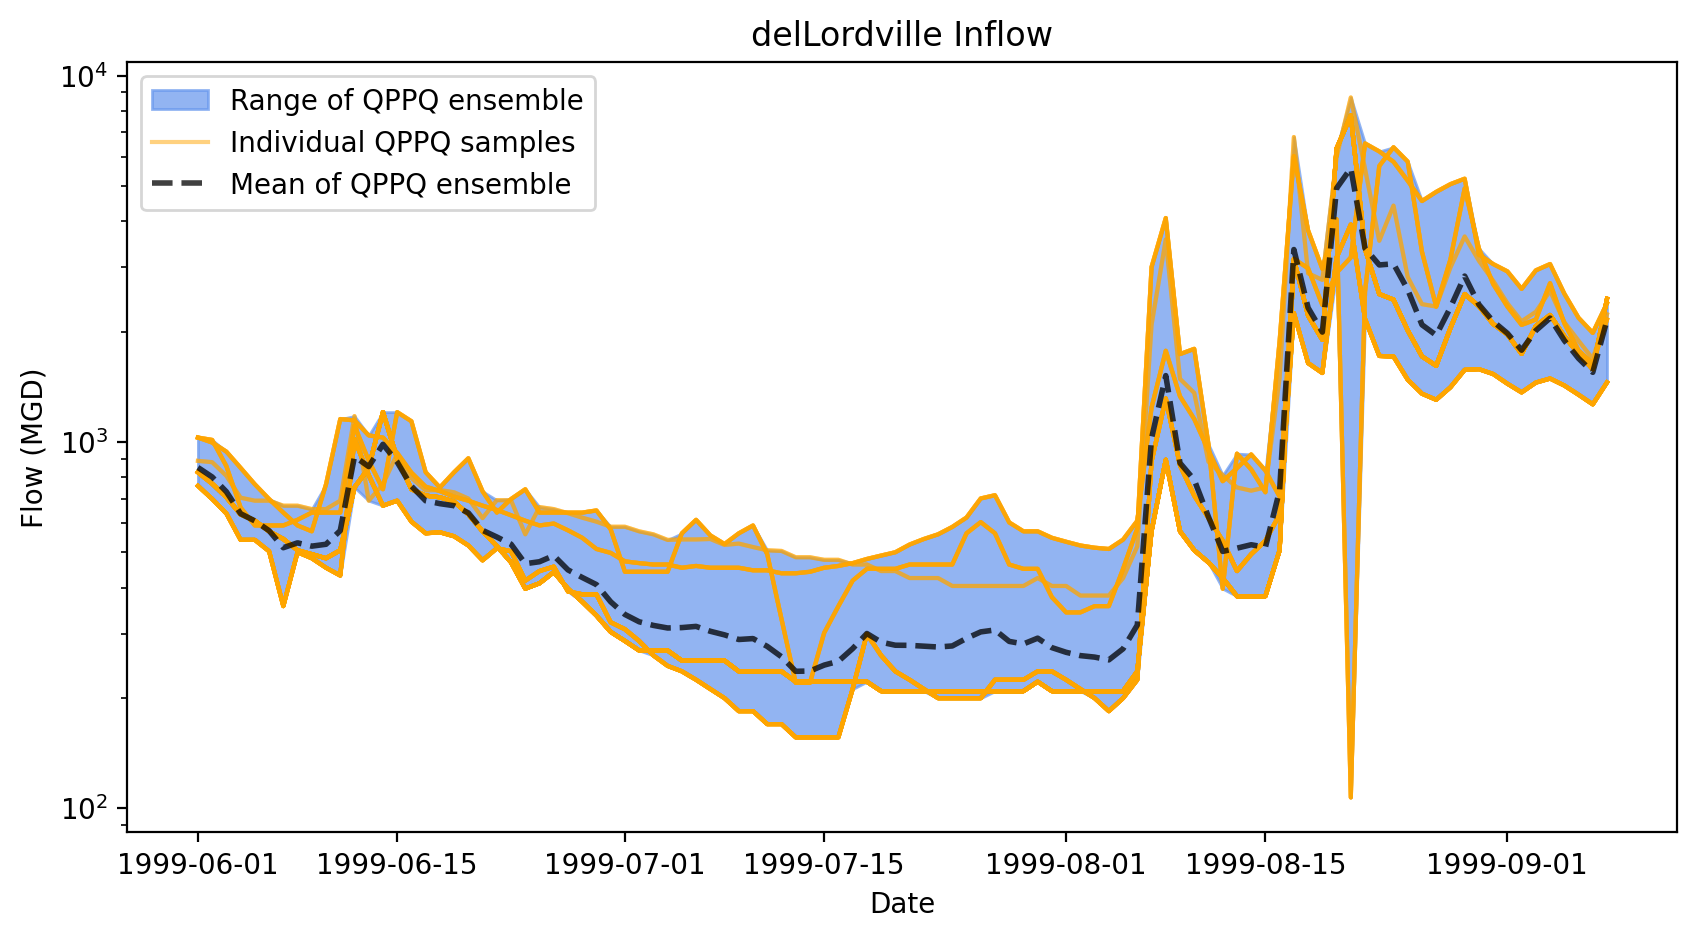

In [103]:
nt = 100

plt.figure(figsize = (10,5), dpi = 200)

plt.fill_between(datetime[0:nt], QPPQ_ensemble[0:nt, :].min(axis=1), QPPQ_ensemble[0:nt, :].max(axis=1), 
                 color = 'cornflowerblue', alpha= 0.7,
                 label = 'Range of QPPQ ensemble')

for i in range(N_ENSEMBLE):
    if i ==0:
        plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, i], color = 'orange', alpha = 0.5, label = 'Individual QPPQ samples')
    else:
        plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, i], color = 'orange', alpha = 0.5)

plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, :].mean(axis=1), color = 'black',lw=2, alpha = 0.75, ls = 'dashed', label = 'Mean of QPPQ ensemble')

plt.ylabel('Flow (MGD)')
plt.yscale('log')
plt.xlabel('Date')
plt.legend()
plt.title(f'{node} Inflow')